In [77]:
%matplotlib inline
import os
import glob
from matplotlib import pyplot as plt

import numpy as np
import nibabel as nb
from nilearn.image import concat_imgs
from nilearn import plotting


import matplotlib as mpl
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.family'] = 'Helvetica'

In [2]:
derivs_home = os.path.expanduser('~/tmp/sherlock')
work_dir = os.path.expanduser('~/tmp/sherlock-work')
fprep_home = os.path.join(derivs_home, 'fmriprep-1.0.3', 'fmriprep')
fprep_pattern = os.path.join(fprep_home, 'sub-*', 'func',
                             'sub-*_task-stopsignal_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')

In [3]:
fprep_files = glob.glob(os.path.join(fprep_home, 'sub-*', 'func',
                        'sub-*_task-stopsignal_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'))

In [4]:
all_mus = []
for f in fprep_files:
    nii = nb.load(f)
    std = nii.get_data().mean(3)
    newnii = nb.Nifti1Image(std, nii.affine, nii.header)
    newnii.set_data_dtype(float)
    all_mus.append(newnii)
    
meannii = concat_imgs(all_mus, auto_resample=True)
meannii.to_filename(os.path.join(work_dir, 'fmriprep_means.nii.gz'))

nb.Nifti1Image(meannii.get_data().std(3), meannii.affine, meannii.header).to_filename(
    os.path.join(work_dir, 'fmriprep_std.nii.gz'))
    

In [5]:
feat_home = os.path.join(derivs_home, 'fslfeat_5.0.9')
feat_files = glob.glob(os.path.join(feat_home, 'sub-*.feat', 'reg',
                       'example_func2standard.nii.gz'))

meannii = concat_imgs([nb.load(f) for f in feat_files], auto_resample=True)
meannii.to_filename(os.path.join(work_dir, 'feat_means.nii.gz'))

nb.Nifti1Image(meannii.get_data().std(3), meannii.affine, meannii.header).to_filename(
    os.path.join(work_dir, 'feat_std.nii.gz'))

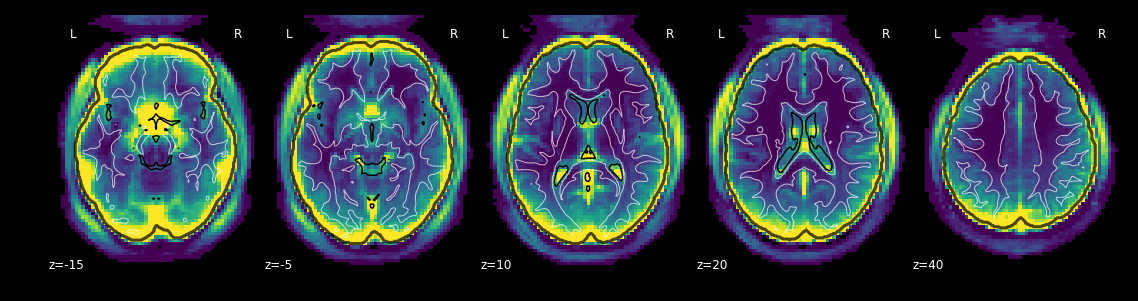

In [6]:
disp = plotting.plot_anat(os.path.join(work_dir, 'fmriprep_std.nii.gz'), display_mode='z', cut_coords=[-15, -5, 10, 20, 40], cmap='viridis', threshold=30, vmin=50, vmax=150)
f = plt.gcf().set_size_inches(15, 3.7)
disp.add_contours(os.path.expanduser('/home/oesteban/.cache/stanford-crn/mni_icbm152_nlin_asym_09c/1mm_tpm_csf.nii.gz'), colors=['k'], levels=[0.8])
disp.add_contours(os.path.expanduser('/home/oesteban/.cache/stanford-crn/mni_icbm152_nlin_asym_09c/1mm_tpm_wm.nii.gz'), colors=['w'], levels=[0.8], linewidths=[1], alpha=0.7)
disp.add_contours(os.path.expanduser('/home/oesteban/.cache/stanford-crn/mni_icbm152_nlin_asym_09c/1mm_brainmask.nii.gz'), colors=['k'], levels=[0.8], linewidths=[3], alpha=.7)
plt.savefig(os.path.join(work_dir, 'fmriprep-std.svg'), format='svg', bbox_inches='tight')

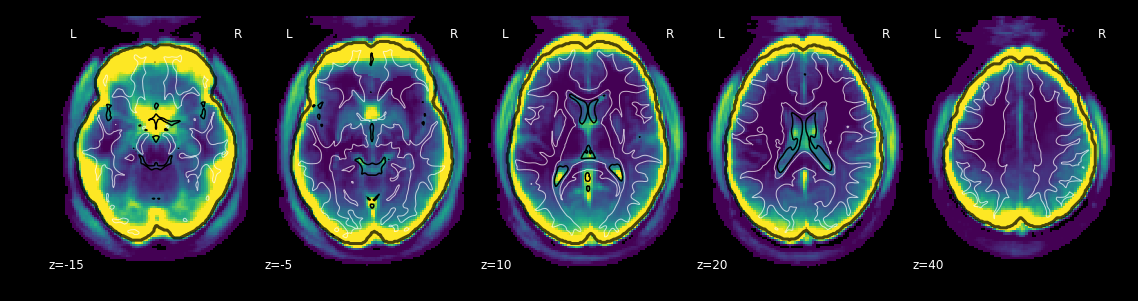

In [7]:
disp = plotting.plot_anat(os.path.join(work_dir, 'feat_std.nii.gz'), display_mode='z', cut_coords=[-15, -5, 10, 20, 40], cmap='viridis', threshold=30, vmin=50, vmax=150)
f = plt.gcf().set_size_inches(15, 3.7)
disp.add_contours(os.path.expanduser('/home/oesteban/.cache/stanford-crn/mni_icbm152_nlin_asym_09c/1mm_tpm_csf.nii.gz'), colors=['k'], levels=[0.8])
disp.add_contours(os.path.expanduser('/home/oesteban/.cache/stanford-crn/mni_icbm152_nlin_asym_09c/1mm_tpm_wm.nii.gz'), colors=['w'], levels=[0.8], linewidths=[1], alpha=0.7)
disp.add_contours(os.path.expanduser('/home/oesteban/.cache/stanford-crn/mni_icbm152_nlin_asym_09c/1mm_brainmask.nii.gz'), colors=['k'], levels=[0.8], linewidths=[3], alpha=.7)
plt.savefig(os.path.join(work_dir, 'feat-std.svg'), format='svg', bbox_inches='tight')

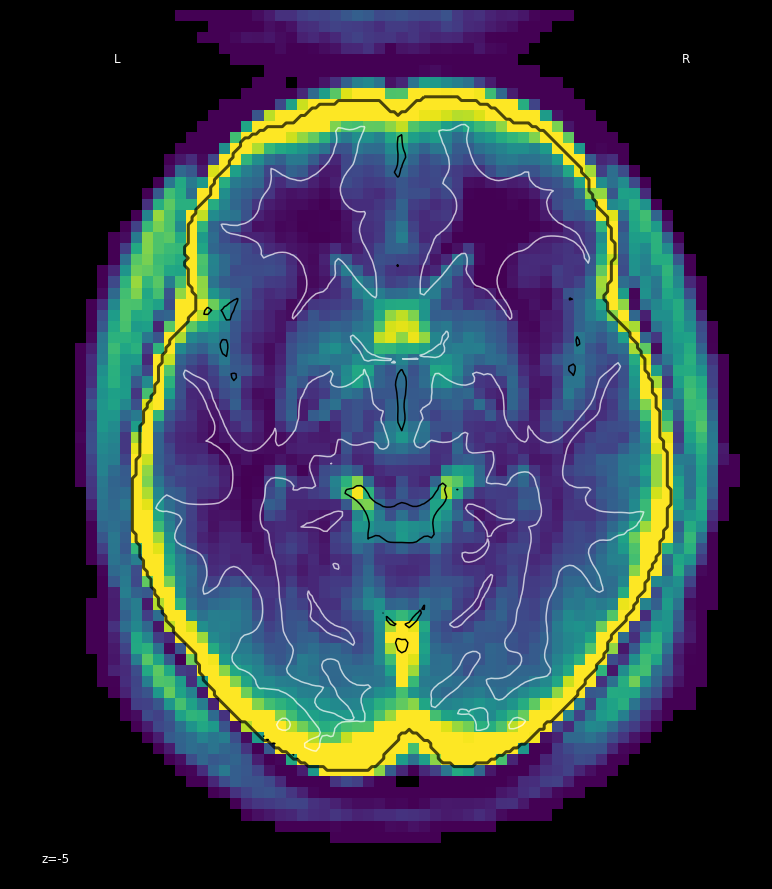

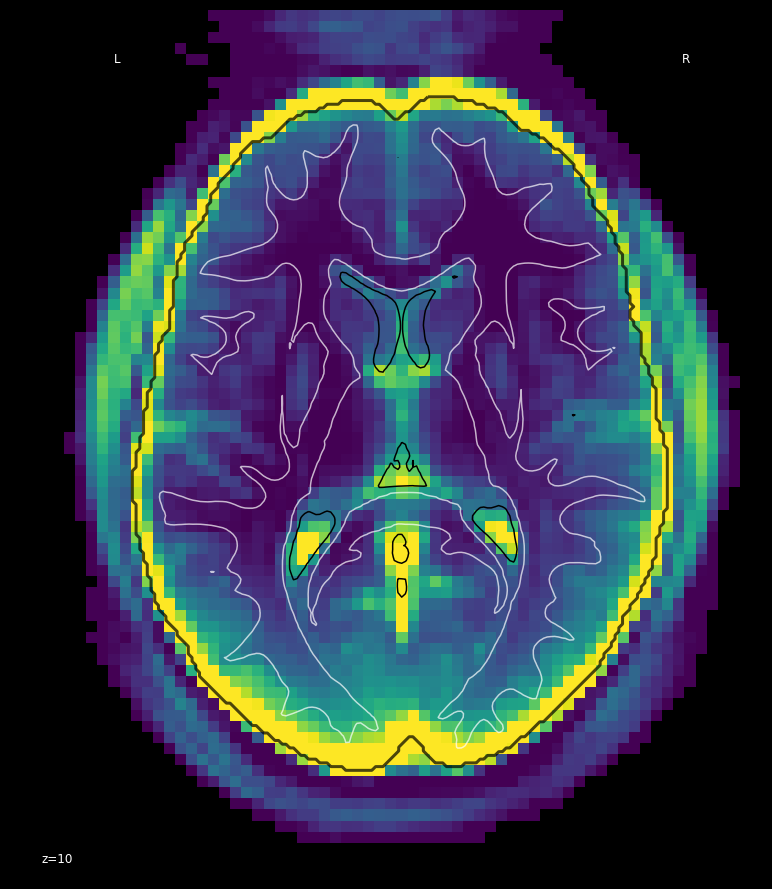

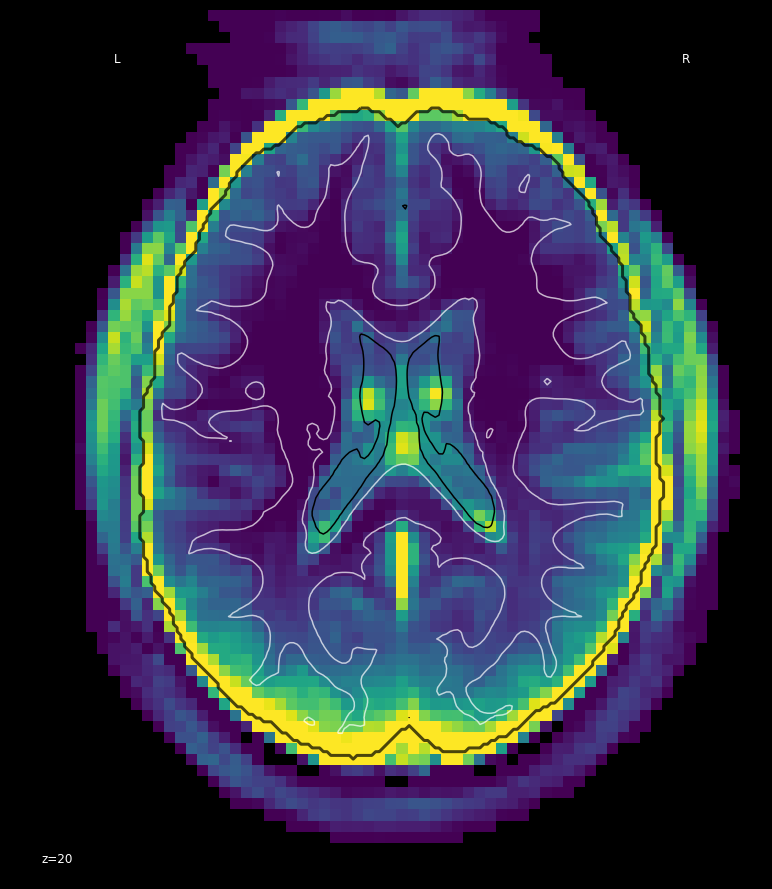

In [8]:
for i, coords in enumerate([-5, 10, 20]):
    disp = plotting.plot_anat(os.path.join(work_dir, 'fmriprep_std.nii.gz'), display_mode='z', cut_coords=[coords], cmap='viridis', threshold=30, vmin=50, vmax=170)
    f = plt.gcf().set_size_inches(10, 20)
    disp.add_contours(os.path.expanduser('/home/oesteban/.cache/stanford-crn/mni_icbm152_nlin_asym_09c/1mm_tpm_csf.nii.gz'), colors=['k'], levels=[0.8])
    disp.add_contours(os.path.expanduser('/home/oesteban/.cache/stanford-crn/mni_icbm152_nlin_asym_09c/1mm_tpm_wm.nii.gz'), colors=['w'], levels=[0.8], alpha=0.7)
    disp.add_contours(os.path.expanduser('/home/oesteban/.cache/stanford-crn/mni_icbm152_nlin_asym_09c/1mm_brainmask.nii.gz'), colors=['k'], levels=[0.8], linewidths=[3], alpha=.7)
    plt.savefig(os.path.join(work_dir, 'fmriprep-std-closeup%03d.svg' % i), format='svg', bbox_inches='tight')

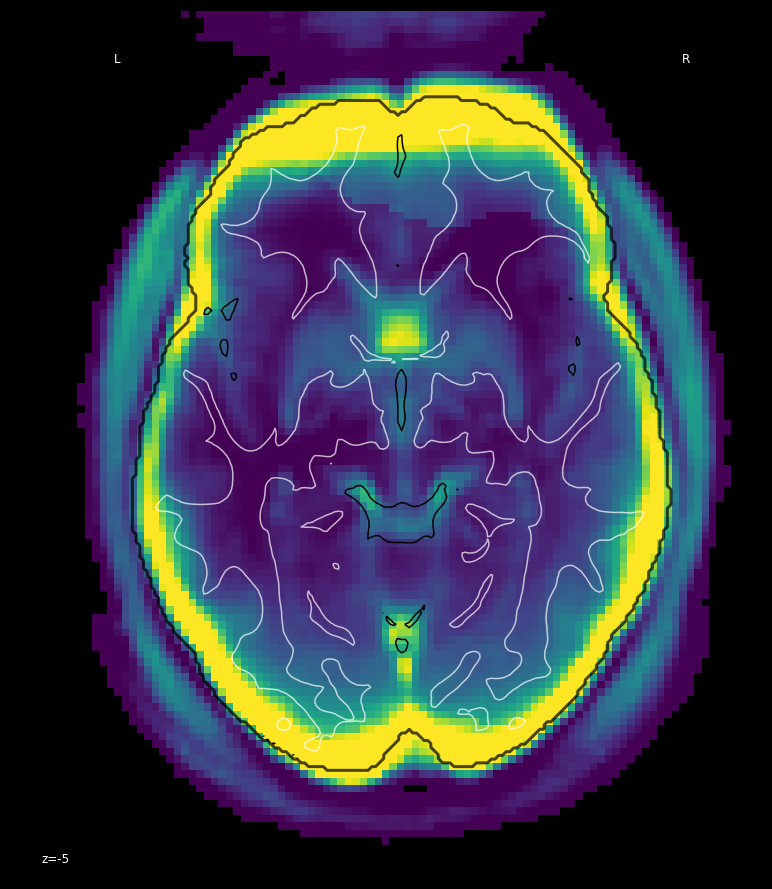

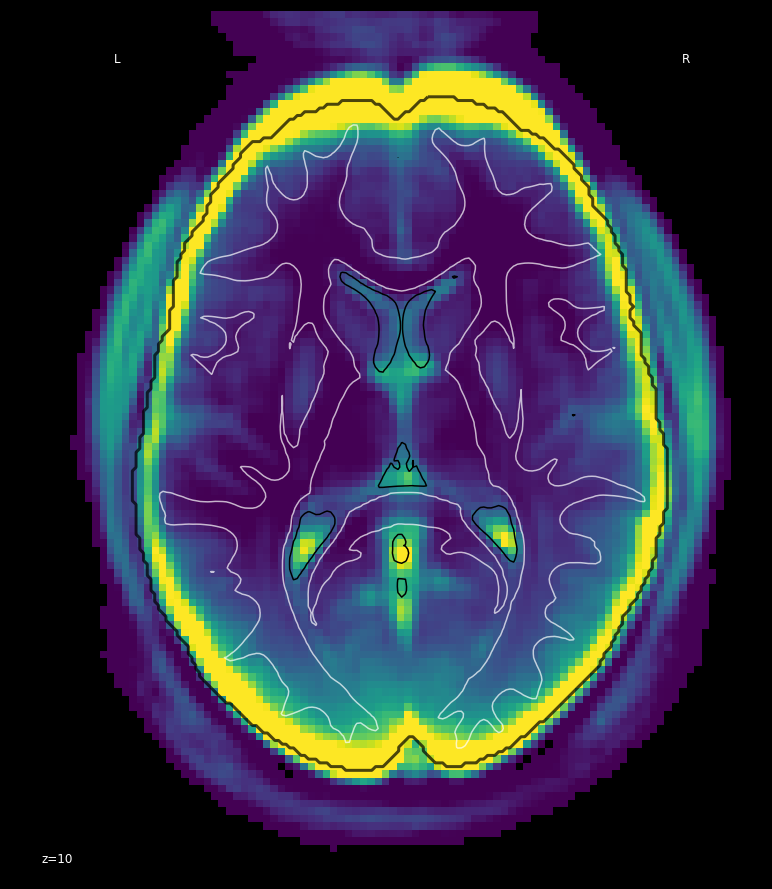

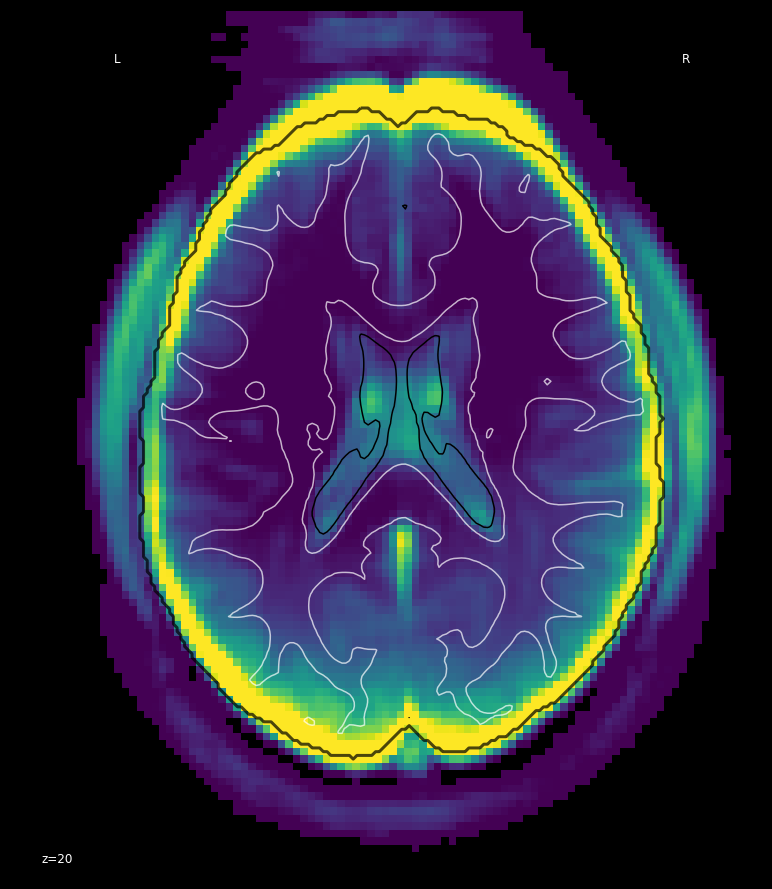

In [9]:
for i, coords in enumerate([-5, 10, 20]):
    disp = plotting.plot_anat(os.path.join(work_dir, 'feat_std.nii.gz'), display_mode='z', cut_coords=[coords], cmap='viridis', threshold=30, vmin=50, vmax=170)
    f = plt.gcf().set_size_inches(10, 20)
    disp.add_contours(os.path.expanduser('/home/oesteban/.cache/stanford-crn/mni_icbm152_nlin_asym_09c/1mm_tpm_csf.nii.gz'), colors=['k'], levels=[0.8])
    disp.add_contours(os.path.expanduser('/home/oesteban/.cache/stanford-crn/mni_icbm152_nlin_asym_09c/1mm_tpm_wm.nii.gz'), colors=['w'], levels=[0.8], alpha=0.7)
    disp.add_contours(os.path.expanduser('/home/oesteban/.cache/stanford-crn/mni_icbm152_nlin_asym_09c/1mm_brainmask.nii.gz'), colors=['k'], levels=[0.8], linewidths=[3], alpha=.7)
    plt.savefig(os.path.join(work_dir, 'feat-std-closeup%03d.svg' % i), format='svg', bbox_inches='tight')

In [132]:
feat_files[137]

'/home/oesteban/tmp/sherlock/fslfeat_5.0.9/sub-10692.feat/reg/example_func2standard.nii.gz'

/home/oesteban/.anaconda3/lib/python3.6/site-packages/nilearn/plotting/glass_brain.py:164: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  black_bg = colors.colorConverter.to_rgba(ax.get_axis_bgcolor()) \


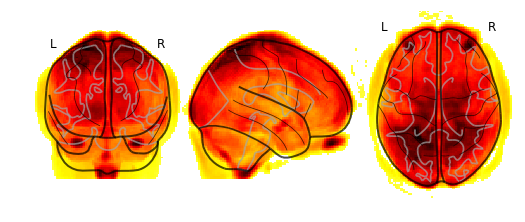

In [133]:
disp = plotting.plot_glass_brain(os.path.join(work_dir, 'feat_std.nii.gz'))

In [78]:
import seaborn as sn
import nilearn as nl

fmriprep_std = nb.load(os.path.join(work_dir, 'fmriprep_std.nii.gz'))
feat_std = nb.load(os.path.join(work_dir, 'feat_std.nii.gz'))
bmask = nb.load(os.path.expanduser('/home/oesteban/.cache/stanford-crn/mni_icbm152_nlin_asym_09c/2mm_brainmask.nii.gz')).get_data()

newmask = nl.image.resample_to_img(os.path.expanduser('/home/oesteban/.cache/stanford-crn/mni_icbm152_nlin_asym_09c/2mm_brainmask.nii.gz'), os.path.join(work_dir, 'fmriprep_std.nii.gz'), interpolation='nearest')

/home/oesteban/.anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


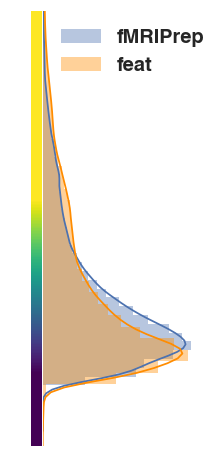

In [81]:
from matplotlib import gridspec
fig = plt.figure(figsize=(3, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 15]) 
fig.subplots_adjust(wspace=0.02)
ax0 = plt.subplot(gs[1])
sn.distplot(fmriprep_std.get_data()[newmask.get_data() > 0], label='fMRIPrep', vertical=True, ax=ax0)
sn.distplot(feat_std.get_data()[bmask == 1], label='feat', vertical=True, color='darkorange', ax=ax0)
plt.gca().set_ylim((0, 300))
plt.legend(prop={'size': 20})
plt.axis('off')

ax1 = fig.add_subplot(gs[0])
gradient = np.hstack((np.zeros((50,)), np.linspace(0, 1, 120), np.ones((130,))))[::-1]
gradient = np.vstack((gradient, gradient))
ax1.imshow(gradient.T, aspect='auto', cmap=plt.get_cmap('viridis'))

plt.axis('off')

plt.savefig(os.path.join(work_dir, 'histogram-colorbar.svg'), format='svg', bbox_inches='tight')